# **Imports**


In [1]:
%matplotlib inline
#!pip install astroquery

import numpy as np
from scipy import constants
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D
import astropy.units as u
from astropy.units import Quantity
from astropy.constants import au
import astropy.units as u
#from astroquery.gaia import Gaia
#Gaia.MAIN_GAIA_TABLE = "gaiadr3.gaia_source"
#Gaia.ROW_LIMIT = -1
from astropy.coordinates.sky_coordinate import SkyCoord
from google.colab import drive
import pandas as pd
from matplotlib import gridspec
from google.colab import output
from astropy.table import QTable, Table, Column
from scipy.integrate import simps
from astropy.visualization import quantity_support
quantity_support()

#suppress warnings
import warnings
warnings.filterwarnings('ignore')

label_font = {'family': 'serif',
        'color':  'black',
        'weight': 'normal',
        'size': 18,
        }

title_font = {'family': 'sans-serif',
        'color':  'black',
        'weight': 'semibold',
        'size': 22.5,
        }


drive.mount('/content/gdrive')
codefold = "/content/gdrive/MyDrive/Tesi_di_laurea/Codes"                        # Cartella del codice
imfold = '/content/gdrive/MyDrive/Tesi_di_laurea/Immagini'                       # Cartella immagini
datafold = str('/content/gdrive/MyDrive/Tesi_di_laurea/Data/SampleData/')

class Cluster: # This class contains information about globular cluster
  def __init__(self, s_ra, s_dec, dist, c, r_cd, r_hd, w0):
    self.ra = s_ra * u.deg            # of its centre
    self.dec = s_dec * u.deg          # of its centre
    self.distance = dist * u.kpc       # Baumgardt
    self.concentration = c
    self.r_core_deg = (r_cd*u.arcmin).to(u.deg)#(r_cd/60) * u.deg             # Core radius in Deg        >Imput in arcmin<
    self.r_halflight_deg = (r_hd/60) * u.deg        # Half-light radius in Deg  >Imput in arcmin<
    self.w0 = w0

NGC6121 = Cluster(s_ra=245.8958, s_dec=-26.5256, dist=1.851, c=1.65, r_cd=1.16, r_hd=4.33, w0=7.41)

output.clear()

# Funzioni

Mock cluster creation

In [ ]:
def angular_distance(ra0, dec0, ra1, dec1):
    '''
    Compute the angular distance between two points on a sphere (coordinates expressed in degrees)
    '''
    d2r = np.pi/180  # degrees to radians
    return 2 * np.arcsin( (np.sin( (dec0-dec1)*0.5 * d2r )**2 +
        np.cos(dec0 * d2r) * np.cos(dec1 * d2r) * np.sin( (ra0-ra1)*0.5 * d2r )**2 )**0.5 ) / d2r

def create_cluster(nstar, radius, sigma=0, covfnc=None):
    '''
    Create a mock cluster of stars.

    Input:
    nstar -- number of stars.
    radius -- radius of the cluster (in degrees); the surface density profile is Gaussian with this radius.
    sigma -- internal PM dispersion of stars in the cluster (imput in km/s); its spatial dependence is
              sigma(R) = sigma / (1 + (R/radius)**2)**0.25
    covfnc -- spatial covariance function of systematic errors; if None then no correlated systematic errors are added,
              only the random (statistical) errors with a realistic distribution of magnitudes.

    Output:
    five arrays that may be provided as input for the routine get_mean_pm:
    ra, dec, pmra, pmdec, pmra_error, pmdec_error, pm_corr
    '''
    rsigma     = radius
    ra         = np.random.normal(size=nstar) * radius
    dec        = np.random.normal(size=nstar) * radius
    sigvar     = sigma / (1 + (ra**2 + dec**2) / rsigma**2)**0.25   # spatially variable dispersion
    pmra       = np.random.normal(size=nstar) * sigvar           # true values
    pmdec      = np.random.normal(size=nstar) * sigvar
    pm_err_mag = np.random.gamma(shape=2, scale=0.5, size=nstar) # size of error ellipse
    pm_err_rat = np.random.uniform(0.2, 1, size=nstar)           # axis ratio of --"--
    pm_err_dir = np.random.uniform(0, np.pi, size=nstar)      # orientation of --"--
    pm_err_maj = pm_err_mag * pm_err_rat**-0.5                      # semimajor axis
    pm_err_min = pm_err_mag * pm_err_rat**0.5                       # semiminor axis
    tan        = np.tan(pm_err_dir)
    pmra_error = ( (pm_err_maj**2 + pm_err_min**2 * tan**2) / (1 + tan**2) )**0.5
    pmdec_error= ( (pm_err_min**2 + pm_err_maj**2 * tan**2) / (1 + tan**2) )**0.5
    pm_corr    = tan / (1 + tan**2) * (pm_err_maj**2 - pm_err_min**2) / (pmra_error * pmdec_error)
    # add errors to the true values of pmra, pmdec
    if not covfnc is None:
        # same steps as in the above routine
        covmat = np.array([ covfnc( angular_distance(ra, dec, ra0, dec0) )
            for ra0, dec0 in zip(ra, dec) ])
        covmat2= np.zeros((2*nstar, 2*nstar))
        covmat2[0::2, 0::2] = covmat
        covmat2[1::2, 1::2] = covmat
        stride = 2*(2*nstar+1)
        covmat2.flat[        0::stride] += pmra_error **2
        covmat2.flat[2*nstar+1::stride] += pmdec_error**2
        covmat2.flat[        1::stride] += pmra_error * pmdec_error * pm_corr
        covmat2.flat[2*nstar  ::stride] += pmra_error * pmdec_error * pm_corr
        chol  = np.linalg.cholesky(covmat2)
        errs  = np.dot(chol, np.random.normal(size=2*nstar))   # noise/measurement errors
        pmra += errs[0::2]
        pmdec+= errs[1::2]
    else:  # simpler case with no correlated errors
        noise1, noise2 = np.random.normal(size=(2,nstar))
        pmra += pmra_error  *  noise1
        pmdec+= pmdec_error * (noise2 * (1-pm_corr**2)**0.5 + noise1 * pm_corr)

    return ra*u.deg, dec*u.deg, pmra*(u.km/u.s), pmdec*(u.km/u.s), pmra_error*(u.km/u.s), pmdec_error*(u.km/u.s), pm_corr

def bins(N):
  return int(1.5*np.sqrt(N))

King distribution sample creation and mass integration

In [ ]:
def king_distribution(rc, c, sample_size=100000):
  '''
  Funzione che genera un campione di dati di dimensione *sample_size* che segue la distribuzione di King
  rho/rho_0 = 1/[1+(r/R_c)^2]^c
  Il raggio del core *rc* deve essere dato in [pc] come imput.
  Verificato che sia consistente con il modello di King generato dalla simulazione N-body di Francesco e Danilo, nel file w0_7_4.txt
  '''
    # Genera campione di valori casuali uniformi
  u = np.random.uniform(0, 1, sample_size)

    # Applica trasformazione della CDF inversa
  r = rc * np.sqrt((u**(-2/c) - 1)**(-1) - 1)

    # Calcola densità di probabilità
  density = 1 / (1 + (r/rc)**2)**c

  return r, density

def M(R):
  '''
  Calcola la massa di un ammasso globulare il cui profilo di densità $\rho$ è dato dal modello di King. La massa al raggio R è calcolata considerando un sample di *nstar* stelle.
  Come range si considera ~ 10^4-10^6 stelle.
  Per integrare uso il metodo Simpson, delle parabole, data la natura della curva dovrebbe essere un'approssimazione migliore.
  '''
  rc = 0.62       # [pc]
  c = 1.65
  r = np.linspace(0, R, 10000)

  M = 4*np.pi*rho0.value*simps(((r**2)/(1 + (r/rc)**2)**c), r)
  return M

# Data files loading

In [ ]:
gc = QTable()
gcDensity = QTable()

gc['r3d']           = np.loadtxt('/content/gdrive/MyDrive/Tesi_di_laurea/Data/SampleData/Positions_797.txt',unpack=True, usecols=(1), skiprows=1)*u.pc
gc['r2d']           = np.loadtxt('/content/gdrive/MyDrive/Tesi_di_laurea/Data/SampleData/Positions_797.txt',unpack=True, usecols=(2), skiprows=1)*u.pc
gc['x']             = np.loadtxt('/content/gdrive/MyDrive/Tesi_di_laurea/Data/SampleData/Positions_797.txt',unpack=True, usecols=(3), skiprows=1)*u.deg
gc['y']             = np.loadtxt('/content/gdrive/MyDrive/Tesi_di_laurea/Data/SampleData/Positions_797.txt',unpack=True, usecols=(4), skiprows=1)*u.deg

gc['vx']            = np.loadtxt('/content/gdrive/MyDrive/Tesi_di_laurea/Data/SampleData/Velocities_797.txt',unpack=True, usecols=(4), skiprows=1)* (u.km/u.s)
gc['vx_err']        = np.loadtxt('/content/gdrive/MyDrive/Tesi_di_laurea/Data/SampleData/Velocities_797.txt',unpack=True, usecols=(5), skiprows=1)* (u.km/u.s)
gc['vy']            = np.loadtxt('/content/gdrive/MyDrive/Tesi_di_laurea/Data/SampleData/Velocities_797.txt',unpack=True, usecols=(6), skiprows=1)* (u.km/u.s)
gc['vy_err']        = np.loadtxt('/content/gdrive/MyDrive/Tesi_di_laurea/Data/SampleData/Velocities_797.txt',unpack=True, usecols=(7), skiprows=1)* (u.km/u.s)
gc['vx_quad']       = np.loadtxt('/content/gdrive/MyDrive/Tesi_di_laurea/Data/SampleData/Velocities_797.txt',unpack=True, usecols=(1), skiprows=1) * (u.km/u.s)**2
gc['vx_quad_err']   = np.loadtxt('/content/gdrive/MyDrive/Tesi_di_laurea/Data/SampleData/Velocities_797.txt',unpack=True, usecols=(2), skiprows=1) * (u.km/u.s)**2
gc['vy_quad']       = np.loadtxt('/content/gdrive/MyDrive/Tesi_di_laurea/Data/SampleData/Velocities_797.txt',unpack=True, usecols=(3), skiprows=1) * (u.km/u.s)**2
gc['vy_quad_err']   = np.loadtxt('/content/gdrive/MyDrive/Tesi_di_laurea/Data/SampleData/Velocities_797.txt',unpack=True, usecols=(4), skiprows=1) * (u.km/u.s)**2
gc['vtot']          = np.loadtxt('/content/gdrive/MyDrive/Tesi_di_laurea/Data/SampleData/Velocities_797.txt',unpack=True, usecols=(5), skiprows=1) * (u.km/u.s)**2
gc['vtot_err']      = np.loadtxt('/content/gdrive/MyDrive/Tesi_di_laurea/Data/SampleData/Velocities_797.txt',unpack=True, usecols=(6), skiprows=1) * (u.km/u.s)**2

gcDensity['2Drho']  = np.loadtxt('/content/gdrive/MyDrive/Tesi_di_laurea/Data/SampleData/Density_42.txt',unpack=True, usecols=(1), skiprows=1)*u.Msun/u.pc**3
gcDensity['2Dr1']   = np.loadtxt('/content/gdrive/MyDrive/Tesi_di_laurea/Data/SampleData/Density_42.txt',unpack=True, usecols=(2), skiprows=1)*u.pc
gcDensity['2Dr2']   = np.loadtxt('/content/gdrive/MyDrive/Tesi_di_laurea/Data/SampleData/Density_42.txt',unpack=True, usecols=(3), skiprows=1)*u.pc
gcDensity['3Drho']  = np.loadtxt('/content/gdrive/MyDrive/Tesi_di_laurea/Data/SampleData/Density_42.txt',unpack=True, usecols=(4), skiprows=1)*u.Msun/u.pc**3
gcDensity['3Dr1']   = np.loadtxt('/content/gdrive/MyDrive/Tesi_di_laurea/Data/SampleData/Density_42.txt',unpack=True, usecols=(5), skiprows=1)*u.pc
gcDensity['3Dr2']   = np.loadtxt('/content/gdrive/MyDrive/Tesi_di_laurea/Data/SampleData/Density_42.txt',unpack=True, usecols=(6), skiprows=1)*u.pc


In [ ]:
# Definiamo alcune grandezze che ci serviranno
G = constants.gravitational_constant * u.m**3/(u.kg*u.s**2)
M_sun = 1.98847e30 * u.kg

D = 1.851*u.kpc#NGC6121.distance.to(u.kpc).to(u.km)
D_error = 0.0155 * u.kpc
Rc = np.tan(NGC6121.r_core_deg)*D.to(u.pc)
Rt = Rc * 10**NGC6121.concentration
Rh_deg = (4.33/60) *u.deg
Rh = np.tan(Rh_deg)*NGC6121.distance.to(u.pc)

#N = len(gc['r3d'])
#nb = int(1.5*np.sqrt(N))

# Mock Cluster

In [ ]:
mock_gc = QTable()

mock_gc['ra'], mock_gc['dec'], mock_gc['pmra'], mock_gc['pmdec'], mock_gc['pmra_error'], mock_gc['pmdec_error'], mock_gc['pm_corr'] = create_cluster(10000, 0.705, 15.327)

mV = 1.5*(mock_gc['pmra']**2 + mock_gc['pmdec']**2)

mV_e = 3*np.sqrt( mock_gc['pmra']**2 * mock_gc['pmra_error']**2 + mock_gc['pmdec']**2 * mock_gc['pmdec_error']**2 )
Vm_e = np.sqrt(sum(i*i for i in mV_e))/len(mV_e)


mock_N = len(mock_gc['ra'])
mock_bin = int(1.5*np.sqrt(len(mock_gc['pmra'])))

Text(0, 0.5, '$v_y$ $[{\\rm km/sec}]$')

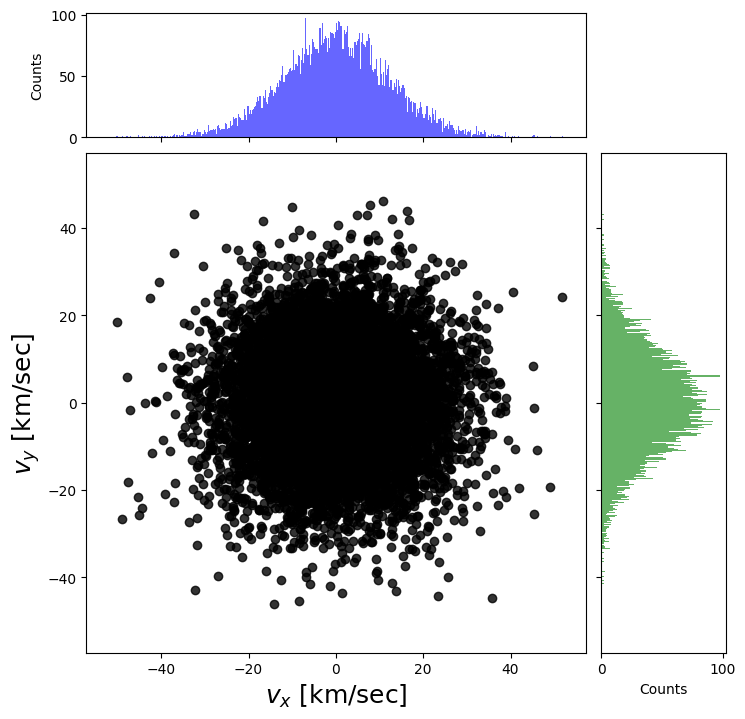

In [ ]:
def scatter_hist(x, y, ax, ax_histx, ax_histy):
    # no labels
    ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histy.tick_params(axis="y", labelleft=False)

    # the scatter plot:
    ax.scatter(x, y, color='black', alpha=0.8)

    # now determine nice limits by hand:
    binwidth = 0.25
    xymax = max(np.max(np.abs(x)), np.max(np.abs(y)))
    lim = (int(xymax/binwidth) + 1) * binwidth

    bins = np.arange(-lim, lim + binwidth, binwidth)
    ax_histx.hist(x, bins=bins, color='blue', alpha=0.6)
    ax_histy.hist(y, bins=bins, orientation='horizontal', color='green', alpha=0.6)

fig = plt.figure(figsize=(8,8))
# Add a gridspec with two rows and two columns and a ratio of 1 to 4 between
# the size of the marginal axes and the main axes in both directions.
# Also adjust the subplot parameters for a square plot.
gs = fig.add_gridspec(2, 2,  width_ratios=(4, 1), height_ratios=(1, 4),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.05)
# Create the Axes.
ax = fig.add_subplot(gs[1, 0])
ax_histx = fig.add_subplot(gs[0, 0], sharex=ax)
ax_histy = fig.add_subplot(gs[1, 1], sharey=ax)
# Draw the scatter plot and marginals.
scatter_hist(mock_gc['pmra'].value, mock_gc['pmdec'].value, ax, ax_histx, ax_histy)
ax_histx.set_ylabel('Counts')
ax_histy.set_xlabel('Counts')
ax.set_xlabel(r'$v_x$ $[{\rm km/sec}]$', fontdict=label_font)
ax.set_ylabel(r'$v_y$ $[{\rm km/sec}]$', fontdict=label_font)

Text(150.19096626068696, 1206.5, '$<v_y^2>$ = 150.19 $\\pm$ 0.36 km$^2$/s$^2$')

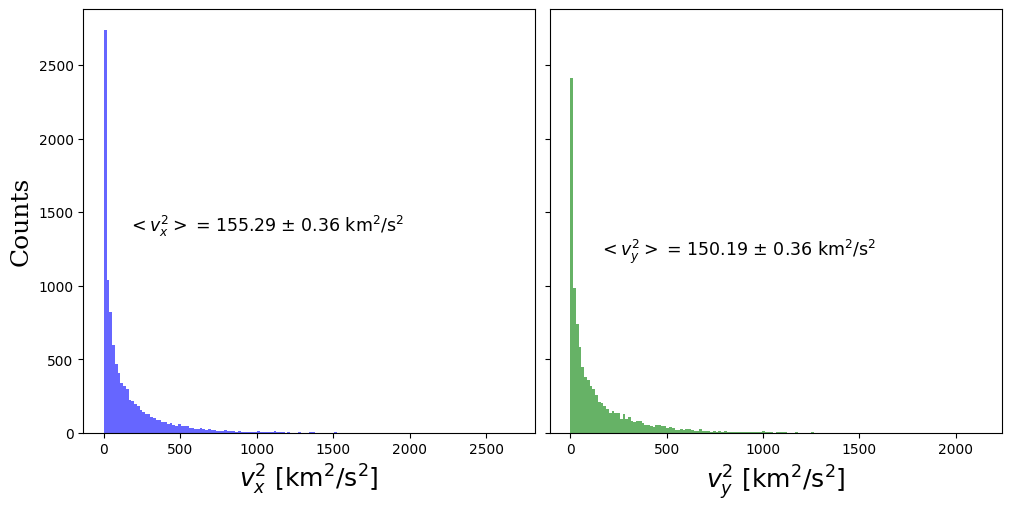

In [ ]:
vx2_e = 2*mock_gc['pmra']*mock_gc['pmra_error']
vy2_e = 2*mock_gc['pmdec']*mock_gc['pmdec_error']

vx2_avg_err = np.sqrt(sum((i*i) for i in vx2_e))/mock_N
vy2_avg_err = np.sqrt(sum((i*i) for i in vy2_e))/mock_N

fig, axs = plt.subplots(1,2,figsize=(10,5), layout='constrained', sharey=True)
fig = plt.subplots_adjust(wspace=0)
vx2h = axs[0].hist(mock_gc['pmra']**2, bins=mock_bin, color='blue', alpha=0.6)
vy2h = axs[1].hist(mock_gc['pmdec']**2, bins=mock_bin, color='green', alpha=0.6)
axs[0].set_xlabel(r'$v_x^2$ $[{\rm km^2/s^{2}}]$', fontdict=label_font)
axs[0].set_ylabel('Counts', fontdict=label_font)
axs[1].set_xlabel(r'$v_y^2$ $[{\rm km^2/s^{2}}]$', fontdict=label_font)
axs[0].text(np.mean(mock_gc['pmra']**2).value ,vx2h[0].max()/2, r'$<v_x^2>$ = {:.2f} $\pm$ {:.2f} km$^2$/s$^2$'.format(np.mean(mock_gc['pmra']**2).value, vx2_avg_err.value), fontsize=12.5)
axs[1].text(np.mean(mock_gc['pmdec']**2).value ,vy2h[0].max()/2, r'$<v_y^2>$ = {:.2f} $\pm$ {:.2f} km$^2$/s$^2$'.format(np.mean(mock_gc['pmdec']**2).value, vy2_avg_err.value), fontsize=12.5)

With a central velocity dispersion of 4.23 km/s we get 12.46 km / s of sigma of the sample at maximum extension (Rt = 0.86°)


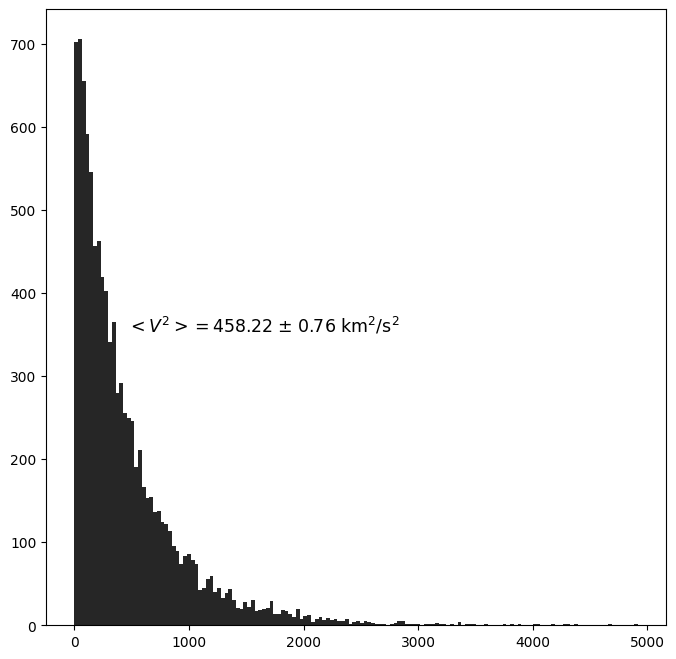

In [ ]:
fig, ax = plt.subplots(figsize=(8,8))
h1 = plt.hist(mV, bins=mock_bin, color='black', alpha=0.85)
#plt.xlim(-10, 400)
ax.text(np.average(mV).value, h1[0].max()/2, r'$<V^2>=${:.2f} $\pm$ {:.2f} km$^2$/s$^2$'.format(np.average(mV).value, Vm_e.value), fontsize=12.5)
output.clear()
print('With a central velocity dispersion of {:.2f} km/s we get {:.2f} of sigma of the sample at maximum extension (Rt = 0.86°)'.format(3.7*(1+(0.72934076/0.86352292)**2)**0.25, np.std(mock_gc['pmra'])))

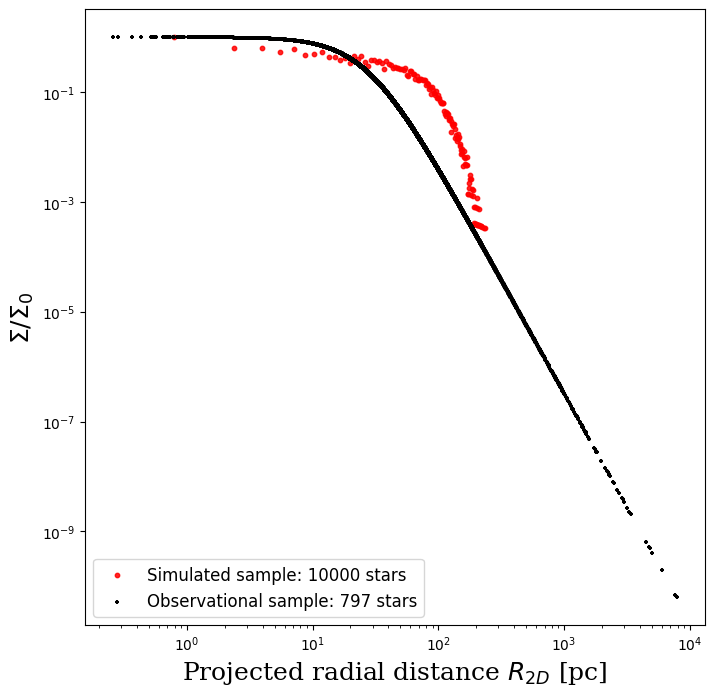

In [ ]:
mock_r, mock_rho = king_distribution(4520*np.tan(0.006), 2.07)
w = angular_distance(0*u.deg, 0*u.deg, mock_gc['ra'], mock_gc['dec'])
mock_r2d = np.tan(w)*D.to(u.pc)
r2dh = np.histogram(mock_r2d, bins=mock_bin)

S = np.zeros(mock_bin)
r1 = np.zeros(mock_bin+1)
r2 = np.zeros(mock_bin+1)

bw = (mock_r2d.to(u.pc).value).max()/mock_bin # [pc]

r1[0] = 0.
r2[0] = bw

for x in range (0, mock_bin):
  S[x] = 2*np.pi*(r2[x]**2 - r1[x]**2)

  r1[x+1] = r1[x] + bw
  r2[x+1] = r2[x] + bw

rho2D = (0.8*M_sun)*r2dh[0]/S


fig, ax = plt.subplots(figsize=(8,8))
plt.scatter((r1[0:(mock_bin)]+r2[0:(mock_bin)])/2, rho2D/rho2D[0], c='red', alpha=0.85, s=10, label='Simulated sample: {:d} stars'.format(mock_N))
plt.scatter(mock_r, mock_rho, marker='+', s=10, c='black', label='Observational sample: {:d} stars'.format(N))
plt.xlabel(r'Projected radial distance $R_{2D}$ [pc]', fontdict=label_font)
plt.ylabel(r'$\Sigma/\Sigma_0$', fontdict=label_font)
plt.legend(fontsize='large')
plt.xscale('log')
plt.yscale('log')

# Valutazione del $\rho_0$ tramite il modello di King e calcolo della M(R)

In [ ]:
King = Table()
nSim = 1000
i = 0
king_rho0 = np.zeros(nSim)

# Creo nSim sample di ammassi da 10^5 stelle che seguono la distrimuzione di king per c=1.65 e ne calcolo il rho_0
# La media di questi rho_0 è il valore che utilizzerò

for i in range (0, nSim):
  King['r'], King['rho'] = king_distribution(0.0062, 2.07)

  king_bins = int(1.5*np.sqrt(len(King)))

  kh = np.histogram(King['r'], bins=king_bins, range=[np.nanmin(King['r']), np.nanmax(King['r'])])

  KV = np.zeros(king_bins)
  R1 = np.zeros(king_bins+1)
  R2 = np.zeros(king_bins+1)

  bw = np.nanmax(King['r'])/king_bins    # [pc]

  R1[0] = 0.
  R2[0] = bw

  for x in range (0, king_bins):
    KV[x] = (4/3)*np.pi*(R2[x]**3 - R1[x]**3)

    R1[x+1] = R1[x] + bw
    R2[x+1] = R2[x] + bw

  king_rho = kh[0]/KV                    # [n/pc^3]
  king_rho0[i] = king_rho[0]*0.8         # [M_sun/pc^3]

rho0 = np.average(king_rho0)*(u.Msun/u.pc**3)
rho0_err = np.std(rho0)/np.sqrt(nSim)
print('rho0 = {:.2e} +- {:.2e}'.format(rho0.value, rho0_err))

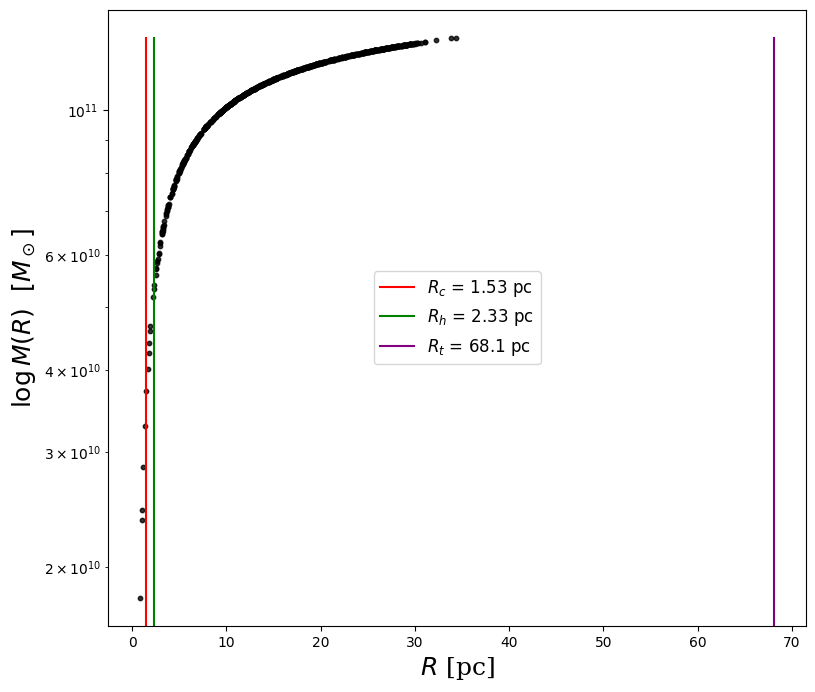

In [ ]:
# Proviamo l'integrazione per trovare M(r)
M_R = np.zeros(N)   # in Masse solari

for x in range (0, N):
  M_R[x] = M(gc['r3d'][x].value)

M_R = M_R * u.Msun

plt.figure(figsize=(9,8))
plt.scatter(gc['r3d'], M_R, c='black', alpha=0.8, s=10)
plt.plot([Rc.value, Rc.value], [0, M_R.value.max()], c='red', label=r'$R_c$ = {:.2f}'.format(Rc))
plt.plot([Rh.value, Rh.value], [0, M_R.value.max()], c='green', label=r'$R_h$ = {:.2f}'.format(Rh))
plt.plot([Rt.value, Rt.value], [0, M_R.value.max()], c='purple', label=r'$R_t$ = {:.1f}'.format(Rt))
plt.ylabel(r'$\log{M(R)}$  $[M_\odot]$', fontdict=label_font)
plt.xlabel(r'$R$ [pc]', fontdict=label_font)
plt.yscale('log')
plt.legend(loc='center', fontsize='large')

In [ ]:
MC = M(Rc.value)
MH = M(Rh.value)
MT = M(Rt.value)

print('M(Rc)/M(Rt) = {:.3f}'.format(MC/MT))
print('M(Rh)/M(Rt) = {:.3f}'.format(MH/MT))

M(Rc)/M(Rt) = 0.266
M(Rh)/M(Rt) = 0.380


In [ ]:
mu = 29.74
print('Computed rho0 = {:.2e}'.format(9e4*u.Msun/(Rc**3 * mu)))
print('Observational rho0 = {:.2e}'.format(gcDensity['3Drho'][0]))

Computed rho0 = 8.53e+02 solMass / pc3
Observational rho0 = 3.06e+00 solMass / pc3


In [ ]:
9e4/(10000*Rc**3)

<Quantity 2.53673345 1 / pc3>

In [ ]:
28/0.62

45.16129032258065

In [ ]:
1.2e4*0.62**3*mu

85054.49663999998

# Potenziale efficace in shell

Calcoliamo il potenziale efficace sulla singola shell. Le shell scelte, numerate in base alla distanza, sono:

nr. 2 = shell0 $\rightarrow$ $R\simeq 5.15{\rm pc}$

nr. 5 = shell1 $\rightarrow$ $R\simeq 15.45{\rm pc}$

nr. 8 = shell2 $\rightarrow$ $R\simeq 25.75{\rm pc}$

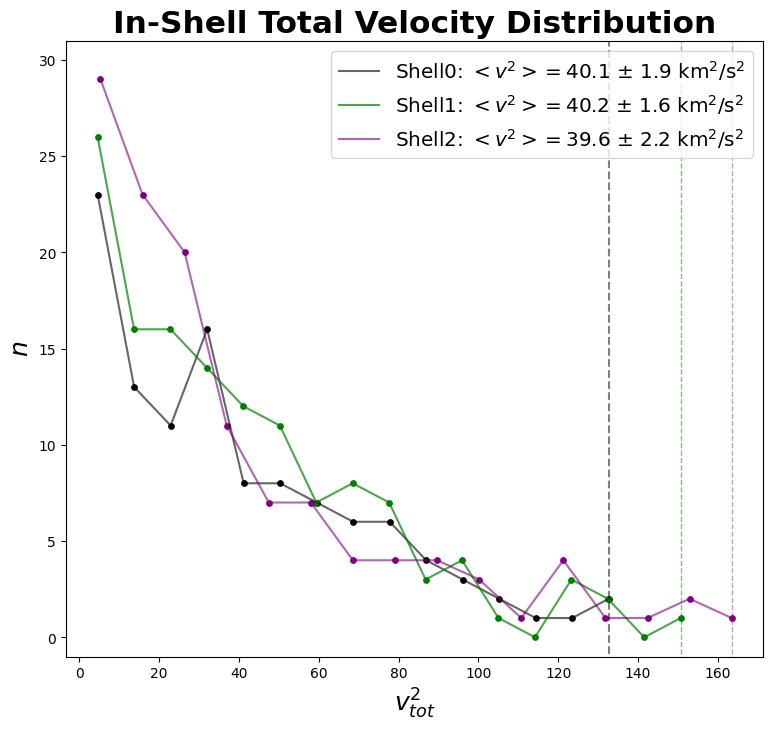

In [2]:
# Costanti e quantità utili

G = constants.gravitational_constant * u.m**3/(u.kg*u.s**2)
M_sun = 1.98847e30 * u.kg

D = 1.851*u.kpc#NGC6121.distance.to(u.kpc).to(u.km)
D_error = 0.0155 * u.kpc
Rc = np.tan(NGC6121.r_core_deg)*D.to(u.pc)
Rt = Rc * 10**NGC6121.concentration
Rh_deg = (4.33/60) *u.deg
Rh = np.tan(Rh_deg)*NGC6121.distance.to(u.pc)

# Dati cluster, istogramma

v2tot,v2tot_err = np.loadtxt('/content/gdrive/MyDrive/Tesi_di_laurea/Data/SampleData/V2_tot.txt', unpack=True, usecols=(2,3), skiprows=1)
N  = np.loadtxt('/content/gdrive/MyDrive/Tesi_di_laurea/Data/SampleData/V2_tot.txt', unpack=True, usecols=(1), skiprows=1)
nbin = int(1.5*np.sqrt(len(v2tot)))

v2max = 45.245530 #km2/s2
v2err = 1.356745  #km2/s2
s = v2tot.max()
xtot = 0.5*v2tot/s
wtot = 0.5*v2tot.max()/s

# Dati shells

shell0 = QTable()
shell1 = QTable()
shell2 = QTable()

shell0['n'], v0 = np.loadtxt("/content/gdrive/MyDrive/Tesi_di_laurea/Data/SampleData/V2_shell2.txt", unpack=True, usecols=(1, 2), skiprows=1)
shell1['n'], v1 = np.loadtxt("/content/gdrive/MyDrive/Tesi_di_laurea/Data/SampleData/V2_shell5.txt", unpack=True, usecols=(1, 2), skiprows=1)
shell2['n'], v2 = np.loadtxt("/content/gdrive/MyDrive/Tesi_di_laurea/Data/SampleData/V2_shell8.txt", unpack=True, usecols=(1, 2), skiprows=1)
V2_m = np.array([40.1, 40.2, 39.6])
V2_e = np.array([1.9, 1.6, 2.2])

plt.figure(figsize=(9,8))
plt.plot(v0, shell0['n'], color='black', linewidth=1.5, alpha=0.6, label=r'Shell0: $<v^2>=${:.1f} $\pm$ {:.1f} km$^2$/s$^2$'.format(V2_m[0], V2_e[0]))
plt.plot(v1, shell1['n'], color='green', linewidth=1.5, alpha=0.7, label=r'Shell1: $<v^2>=${:.1f} $\pm$ {:.1f} km$^2$/s$^2$'.format(V2_m[1], V2_e[1]))
plt.plot(v2, shell2['n'], color='purple', linewidth=1.5, alpha=0.6, label=r'Shell2: $<v^2>=${:.1f} $\pm$ {:.1f} km$^2$/s$^2$'.format(V2_m[2], V2_e[2]))
plt.scatter(v0, shell0['n'], color='black', s=15)
plt.scatter(v1, shell1['n'], color='green', s=15)
plt.scatter(v2, shell2['n'], color='purple', s=15)
plt.plot([v0.max(), v0.max()], [-2,37], color='black', alpha=0.5, linestyle="--", linewidth=1.5)
plt.plot([v1.max(), v1.max()], [-2,37], color='green', alpha=0.5, linestyle="--", linewidth=1.0)
plt.plot([v2.max(), v2.max()], [-2,37], color='purple',alpha=0.4, linestyle="--", linewidth=1.0)
plt.xlabel(r'$v^2_{tot}$', fontdict=label_font)
plt.ylabel(r'$n$', fontdict=label_font)
plt.ylim(-1,31)
plt.title('In-Shell Total Velocity Distribution', fontdict=title_font)
plt.legend(loc='upper right', fontsize='x-large')

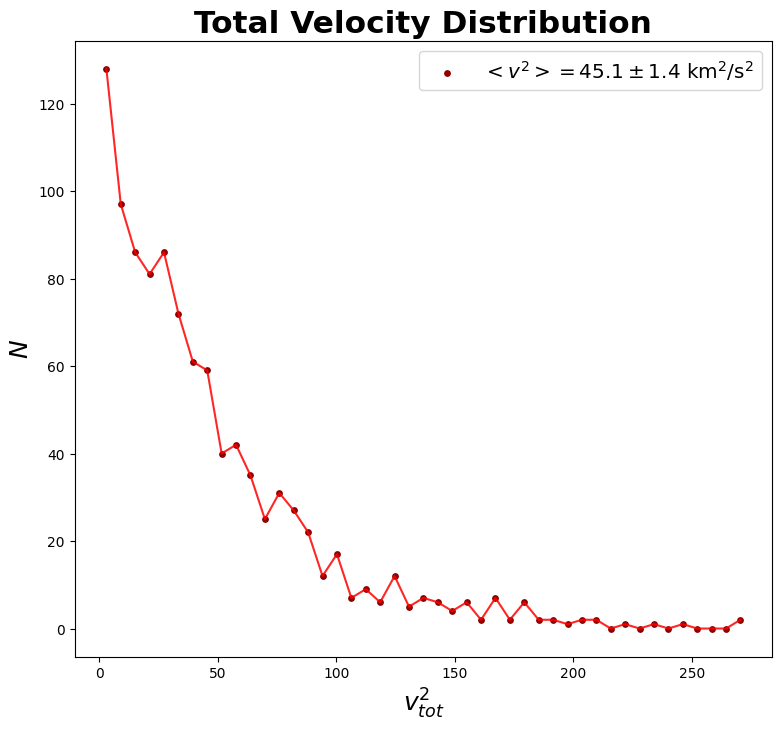

In [3]:
plt.figure(figsize=(9,8))
plt.plot(v2tot, N, c='red', alpha=0.85)
plt.scatter(v2tot, N, c='darkred', s=15, label=r'$<v^2>=45.1\pm1.4$ km$^2$/s$^2$')
plt.xlabel(r'$v^2_{tot}$', fontdict=label_font)
plt.ylabel(r'$N$', fontdict=label_font)
plt.title('Total Velocity Distribution', fontdict=title_font)
plt.legend(fontsize='x-large')

We want to calculate

> $\Sigma = \ln B - \ln{\frac{\Delta N^*}{\sqrt{x}}} - x $

where

> $\Sigma = \frac{m\psi}{k\theta}$

is the adimensional effective potential. B is a constant defined (in the shell) as

> $B= 16\sqrt{2}\pi^2\alpha\beta^2r_*^2\Delta r A m^3 \sigma^3\Delta x$

$\beta$ tiene conto dell'incertezza sul valore vero di r, mentre $\alpha$ tiene conto del fatto che il nostro sample è incompleto, e quindi il $\Delta N$ vero sarà maggiore del $\Delta N^*$ che abbiamo a disposizione



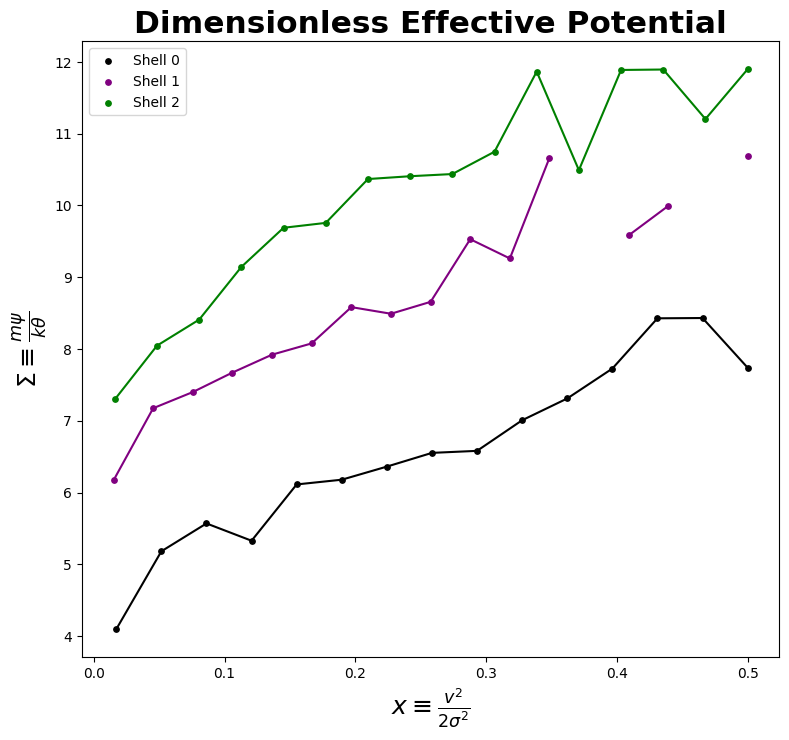

In [4]:
# Calcolo del w e della velocità critica teorica per ogni shell

xi, w = np.loadtxt('/content/gdrive/MyDrive/Tesi_di_laurea/Data/w0_7_4.txt', unpack=True, usecols=(1,2), skiprows=1)
fulldata = QTable()
fulldata['v2'], fulldata['v2_err'], fulldata['R'] = np.loadtxt('/content/gdrive/MyDrive/Tesi_di_laurea/Data/SampleData/V2.txt', unpack=True, usecols=(1,2,3), skiprows=1)

target = np.array([0.1863799, 0.5580645, 0.6179211, 0.9297491])                 # 5.19 - 15.57 - 17.3 - 25.97
target1 = fulldata['R'] / Rt

xim = np.zeros(4)
wm = np.zeros(4)

j = 0
for i in range (0, len(xi)-1):
  if (target[j] < xi[i+1] and target[j] > xi[i]):
    xi1 = xi[i]
    xi2 = xi[i+1]
    wi1 = w[i]
    wi2 = w[i+1]
    wm[j] = 0.5*(wi1 + wi2)
    xim[j] = 0.5*(xi1 + xi2)
    while xim[j] != target[j]:
      xim[j] = 0.5*(xi1 + xi2)
      if xim[j] < target[j]:
        xi1 = xim[j]
      if xim[j] > target[j]:
        xi2 = xim[j]
    j += 1
  if j==len(target):
    break

sigma =  np.array([np.sqrt(v0.max()), np.sqrt(v1.max()), np.sqrt(v2.max())])         #np.array([0.5*v0.max()/wm[0], 0.5*v1.max()/wm[1], 0.5*v2.max()/wm[3]])    #np.array([s,s,s])

Vcrit = np.array([0,0,0,0])
Sr = np.array([0,0,0,0])
Vcrit[0] = 2*s*wm[0]
Vcrit[1] = 2*s*wm[1]
Vcrit[2] = 2*s*wm[2]
Vcrit[3] = 2*s*wm[3]
Sr[0] = sigma[0]**2/(2*wm[0])
Sr[1] = sigma[0]**2/(2*wm[1])
Sr[3] = sigma[0]**2/(2*wm[3])
Sr[2] = s/(2*wm[2])

vc = 2*s*w

# Calcolo potenziale efficace

shell0['x'] = v0/(2*sigma[0]**2)
shell1['x'] = v1/(2*sigma[1]**2)
shell2['x'] = v2/(2*sigma[2]**2)

dx = np.array([shell0['x'][1]-shell0['x'][0], shell1['x'][1]-shell1['x'][0], shell2['x'][1]-shell2['x'][0]])

R = np.array([5.150237, 15.450710, 25.751184])                                  # pc
dr = 3.433491                                                                   # pc

# Parametri
alpha = 0.01
beta = 1.
m = 1.
A = 1.
B = 16*2**0.5*(np.pi*R)**2*(m*sigma)**3*dx*dr*alpha*beta*A
lnB = np.log(B)

P0 = lnB[0] - np.log(shell0['n']/(shell0['x']**0.5)) - shell0['x']
P1 = lnB[1] - np.log(shell1['n']/(shell1['x']**0.5)) - shell1['x']
P2 = lnB[2] - np.log(shell2['n']/(shell2['x']**0.5)) - shell2['x']


fig, ax = plt.subplots(figsize=(9,8))
plt.scatter(shell0['x'], P0, c='black', label='Shell 0', s=15)
plt.plot(shell0['x'], P0, c='black')
plt.scatter(shell1['x'], P1, c='purple', label='Shell 1', s=15)
plt.plot(shell1['x'], P1, c='purple')
plt.scatter(shell2['x'], P2, c='green', label='Shell 2', s=15)
plt.plot(shell2['x'], P2, c='green')
plt.title(r'Dimensionless Effective Potential', fontdict=title_font)
plt.xlabel(r'$x \equiv \frac{v^2}{2\sigma^2}$', fontdict=label_font)
plt.ylabel(r'$\Sigma \equiv \frac{m\psi}{k\theta}$', fontdict=label_font)
plt.legend(loc='upper left')

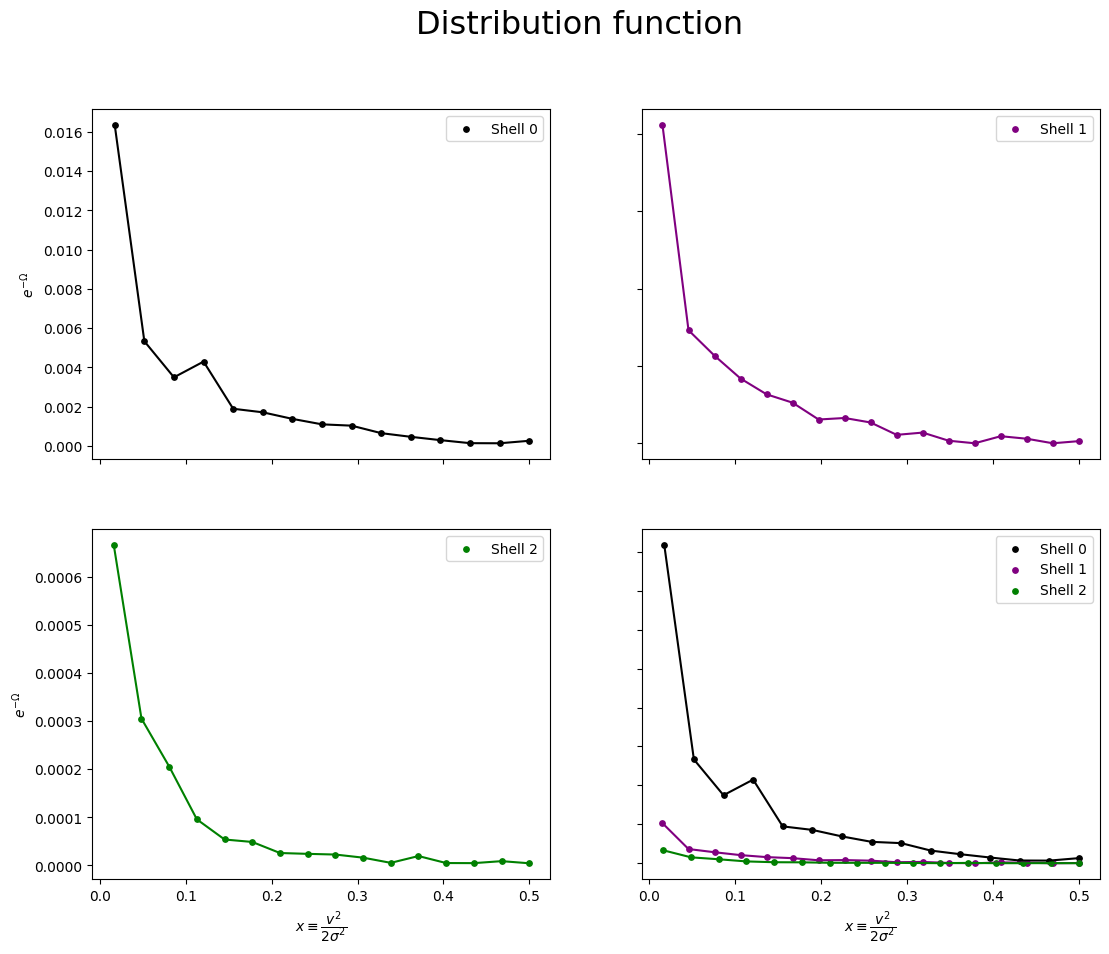

In [5]:
fig, axs = plt.subplots(2,2,figsize=(13,10), sharex=True)
axs[0,0].scatter(shell0['x'], np.exp(-P0-shell0['x']), c='black', label='Shell 0', s=15)
axs[0,0].plot(shell0['x'], np.exp(-P0-shell0['x']), c='black')
axs[0,1].scatter(shell1['x'], np.exp(-P1-shell1['x']), c='purple', label='Shell 1', s=15)
axs[0,1].plot(shell1['x'], np.exp(-P1-shell1['x']), c='purple')
axs[1,0].scatter(shell2['x'], np.exp(-P2-shell2['x']), c='green', label='Shell 2', s=15)
axs[1,0].plot(shell2['x'], np.exp(-P2-shell2['x']), c='green')

axs[1,1].scatter(shell0['x'], np.exp(-P0-shell0['x']), c='black', label='Shell 0', s=15)
axs[1,1].plot(shell0['x'], np.exp(-P0-shell0['x']), c='black')
axs[1,1].scatter(shell1['x'], np.exp(-P1-shell1['x']), c='purple', label='Shell 1', s=15)
axs[1,1].plot(shell1['x'], np.exp(-P1-shell1['x']), c='purple')
axs[1,1].scatter(shell2['x'], np.exp(-P2-shell2['x']), c='green', label='Shell 2', s=15)
axs[1,1].plot(shell2['x'], np.exp(-P2-shell2['x']), c='green')

fig.suptitle('Distribution function', fontsize=23)

for ax in axs.flat:
    ax.set(xlabel=r'$x\equiv\dfrac{v^2}{2\sigma^2}$', ylabel=r'$e^{-\Omega}$')
    ax.legend()

for ax in axs.flat:
    ax.label_outer()

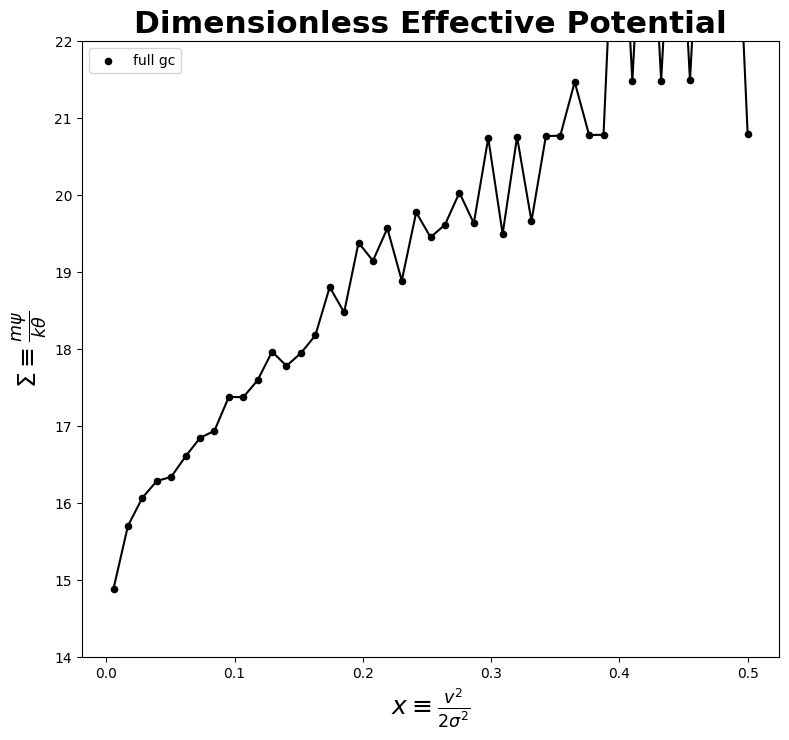

In [6]:
# Full gc effective potential (approximation)

dxt = xtot[1]-xtot[0]
R2 = 0.017179*1000                                 # pc
dr2 = 3.433491*10                                  # pc
# Parametri
alpha = 0.01
beta = 1.
m = 1.
A = 1.
Btot = 16*2**0.5*(np.pi*R2)**2*(m*s)**3*dxt*dr2*alpha*beta*A
lnB2 = np.log(Btot)

Ptot = lnB2 - np.log(N/(xtot**0.5)) - xtot
Ptot_err = 0.5*(N - 2*xtot)/xtot *dxt

Ptot[np.isinf(Ptot)] = 25

fig, ax = plt.subplots(figsize=(9,8))
plt.scatter(xtot, Ptot, c='black', label='full gc', s=20)
plt.plot(xtot, Ptot, c='black')
plt.title(r'Dimensionless Effective Potential', fontdict=title_font)
plt.xlabel(r'$x \equiv \frac{v^2}{2\sigma^2}$', fontdict=label_font)
plt.ylabel(r'$\Sigma \equiv \frac{m\psi}{k\theta}$', fontdict=label_font)
#ax.errorbar(xtot[0:35], Ptot[0:35], yerr=Ptot_err[0:35], c='black', ecolor='black', capsize=2.5)
plt.ylim(14,22)
plt.legend(loc='upper left')

Another way to calculate the adimensional effective potential is through the formula

> $\frac{m\psi}{k\theta} \equiv \Sigma = -\ln{\big(1-e^{x-w}\big)}$

where $x=\frac{v^2}{2\sigma^2}$ and $w=\frac{v^2_{max}}{2\sigma^2}$


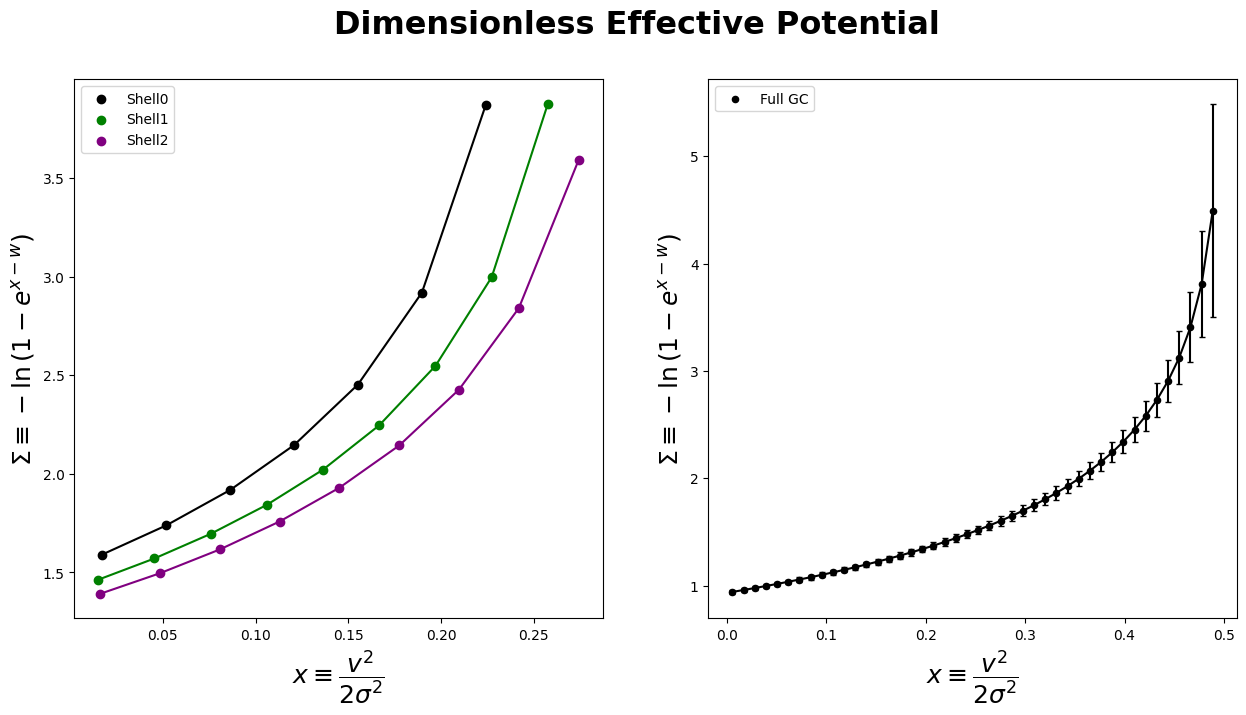

In [7]:
#w0 = shell0['x'].max()
w0 = np.max(0.5*v0/s)
x0 = shell0['x']

#w1 = shell1['x'].max()
w1 = np.max(0.5*v1/s)                           # Metodo 1: Normalizzazione per shell - Metodo 2: Normalizzazione comune
x1 = shell1['x']

#w2 = shell2['x'].max()
w2 = np.max(0.5*v2/s)
x2 = shell2['x']

p0 = -np.log(1-np.exp(x0-w0))
p1 = -np.log(1-np.exp(x1-w1))
p2 = -np.log(1-np.exp(x2-w2))

Omega0 = p0 + x0
f0 = A*np.exp(-Omega0)
Omega1 = p1 + x1
f1 = A*np.exp(-Omega1)
Omega2 = p2 + x2
f2 = A*np.exp(-Omega2)

ptot = -np.log(1-np.exp(xtot-wtot))
ptot_err = 1/(np.exp(-xtot+wtot) - 1) * dxt

OmegaT = ptot + xtot
fT = A*np.exp(-OmegaT)

fig, axs = plt.subplots(1, 2, figsize=(15,7))
axs[0].plot(x0, p0, c='black')
axs[0].scatter(x0, p0, c='black', label='Shell0')
axs[0].plot(x1, p1, c='green')
axs[0].scatter(x1, p1, c='green', label='Shell1')
axs[0].plot(x2, p2, c='purple')
axs[0].scatter(x2, p2, c='purple', label='Shell2')
axs[0].legend(loc='best')
axs[0].set_xlabel(r'$x\equiv\dfrac{v^2}{2\sigma^2}$', fontdict=label_font)
axs[0].set_ylabel(r'$\Sigma\equiv -\ln{(1-e^{x-w})}$', fontdict=label_font)
fig.suptitle('Dimensionless Effective Potential', fontsize=23, fontweight='bold')

axs[1].errorbar(xtot, ptot, yerr=ptot_err, c='black', ecolor='black', capsize=2.5)
axs[1].scatter(xtot, ptot, c='black', label='Full GC', s=20)
axs[1].set_xlabel(r'$x\equiv\dfrac{v^2}{2\sigma^2}$', fontdict=label_font)
axs[1].set_ylabel(r'$\Sigma\equiv -\ln{(1-e^{x-w})}$', fontdict=label_font)
axs[1].legend(loc='best')

Text(0, 0.5, '$\\Sigma\\equiv -\\ln{(1-e^{x-w})}$')

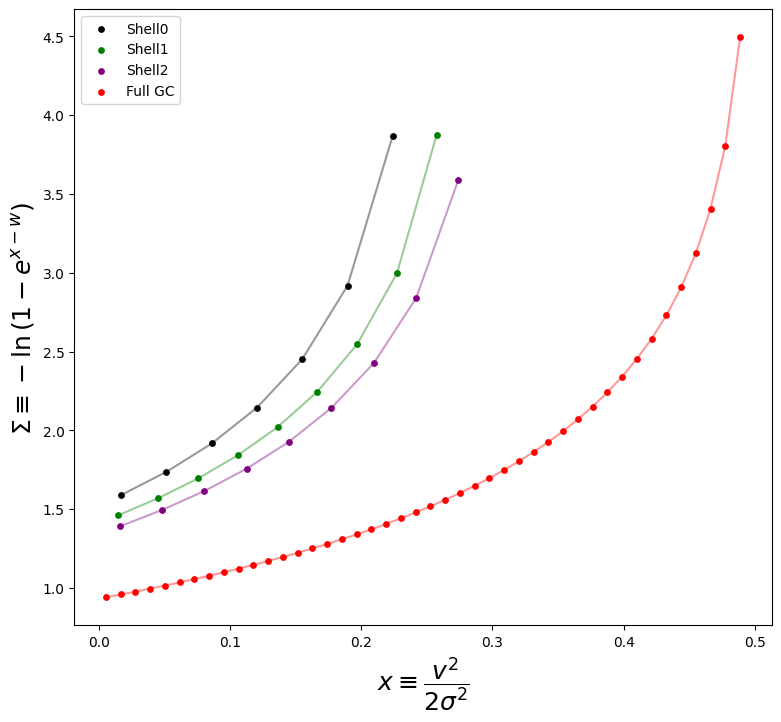

In [8]:
fig, ax = plt.subplots(figsize=(9,8))
plt.plot(x0, p0, c='black', alpha=0.4)
plt.scatter(x0, p0, c='black', label='Shell0', s=15)
plt.plot(x1, p1, c='green', alpha=0.4)
plt.scatter(x1, p1, c='green', label='Shell1', s=15)
plt.plot(x2, p2, c='purple', alpha=0.4)
plt.scatter(x2, p2, c='purple', label='Shell2', s=15)
plt.plot(xtot, ptot, c='red', alpha=0.4)
plt.scatter(xtot, ptot, c='red', label='Full GC', s=15)
plt.legend(loc='best')
plt.xlabel(r'$x\equiv\dfrac{v^2}{2\sigma^2}$', fontdict=label_font)
plt.ylabel(r'$\Sigma\equiv -\ln{(1-e^{x-w})}$', fontdict=label_font)

Text(0.5, 1.0, 'Escape Velocity')

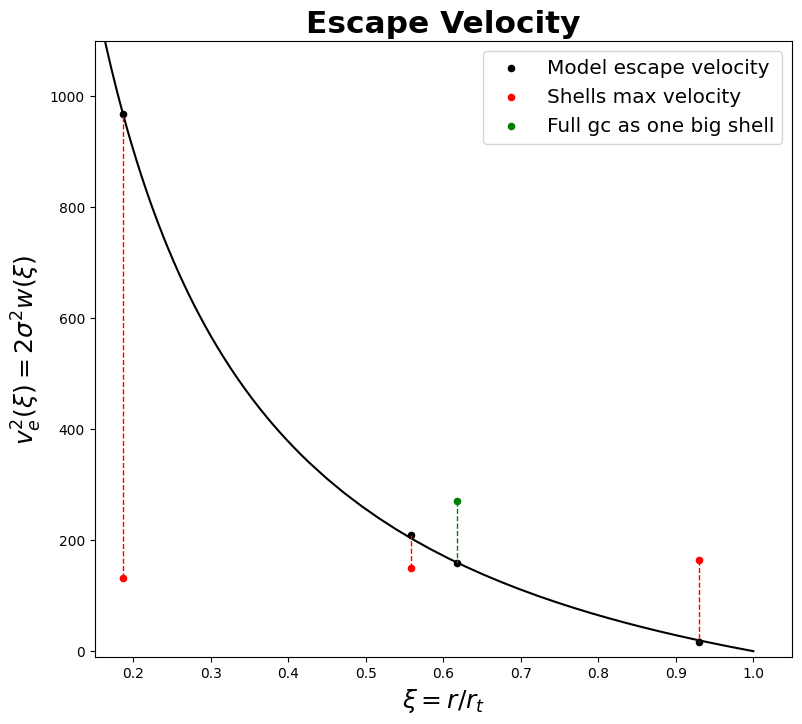

In [9]:
plt.subplots(figsize=(9,8))
plt.scatter(xim, Vcrit, c='black', label='Model escape velocity', s=20)
plt.scatter(xim[0:2], sigma[0:2]**2, c='red', label='Shells max velocity', s=20)
plt.scatter(xim[3], sigma[2]**2, c='red', s=20)
plt.scatter(xim[2], s, c='green', label='Full gc as one big shell', s=20)
plt.plot(xi, vc, c='black')
plt.plot([xim[0], xim[0]], [sigma[0]**2, Vcrit[0]], c='red', linestyle='--', linewidth=1)
plt.plot([xim[1], xim[1]], [sigma[1]**2, Vcrit[1]], c='red', linestyle='--', linewidth=1)
plt.plot([xim[3], xim[3]], [sigma[2]**2, Vcrit[3]], c='red', linestyle='--', linewidth=1)
plt.plot([xim[2], xim[2]], [s, Vcrit[2]], c='green', linestyle='--', linewidth=1)
plt.ylabel(r'$v^2_e(\xi) = 2\sigma^2w(\xi)$', fontdict=label_font)
plt.xlabel(r'$\xi=r/r_t}$', fontdict=label_font)
plt.legend(fontsize='x-large')
plt.ylim(-10, 1100)
plt.xlim(0.15, 1.05)
plt.title('Escape Velocity', fontdict=title_font)

#Grafici utili per checks e prove

n° of zeros, aka points with R > Rt: 74


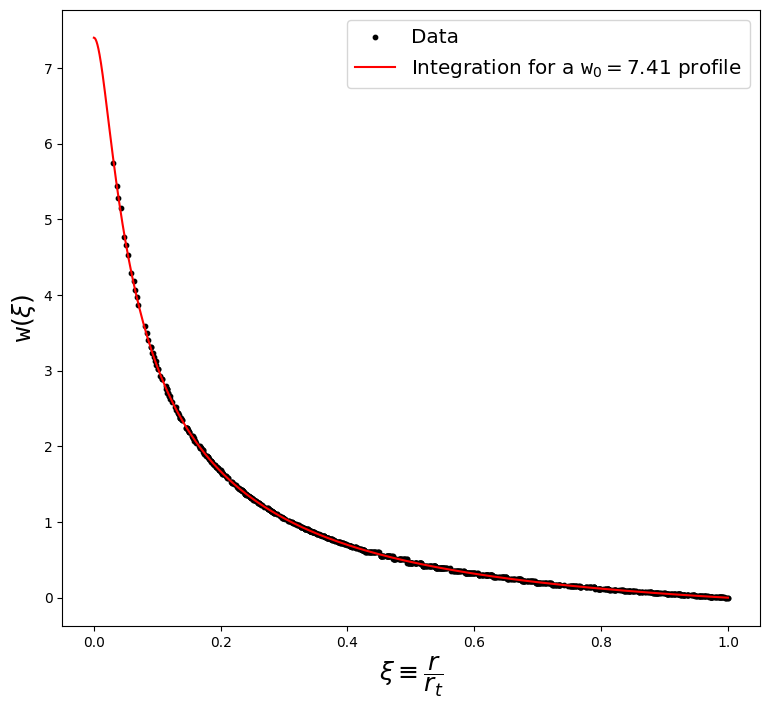

In [10]:
target1 = (fulldata['R'] / Rt).value

xidata = np.zeros(len(fulldata['R']))
wdata = np.zeros(len(fulldata['R']))

for j in range(0, len(target1)):
  for i in range (0, len(xi)-1):
    if (target1[j] < xi[i+1] and target1[j] > xi[i]):
      xi1 = xi[i]
      xi2 = xi[i+1]
      wi1 = w[i]
      wi2 = w[i+1]
      wdata[j] = 0.5*(wi1 + wi2)
      xidata[j] = 0.5*(xi1 + xi2)
      while xidata[j] != target1[j]:
        xidata[j] = 0.5*(xi1 + xi2)
        if xidata[j] < target1[j]:
          xi1 = xidata[j]
        if xidata[j] > target1[j]:
          xi2 = xidata[j]
k=0
for x in range(0,len(wdata)):
  if wdata[x] == 0. and xidata[x]==0.:
    k += 1
    xidata[x]=np.nan

fig, ax = plt.subplots(figsize=(9,8))
plt.scatter(xidata, wdata, c='black', s=10, label='Data')
plt.plot(xi, w, c='red', label=r'Integration for a $\mathtt{w}_0=7.41$ profile')
plt.legend(fontsize='x-large')
plt.xlabel(r'$\xi\equiv \dfrac{r}{r_t}$', fontdict=label_font)
plt.ylabel(r'$\mathtt{w}(\xi)$', fontdict=label_font)

print('n° of zeros, aka points with R > Rt: {:d}'.format(k))

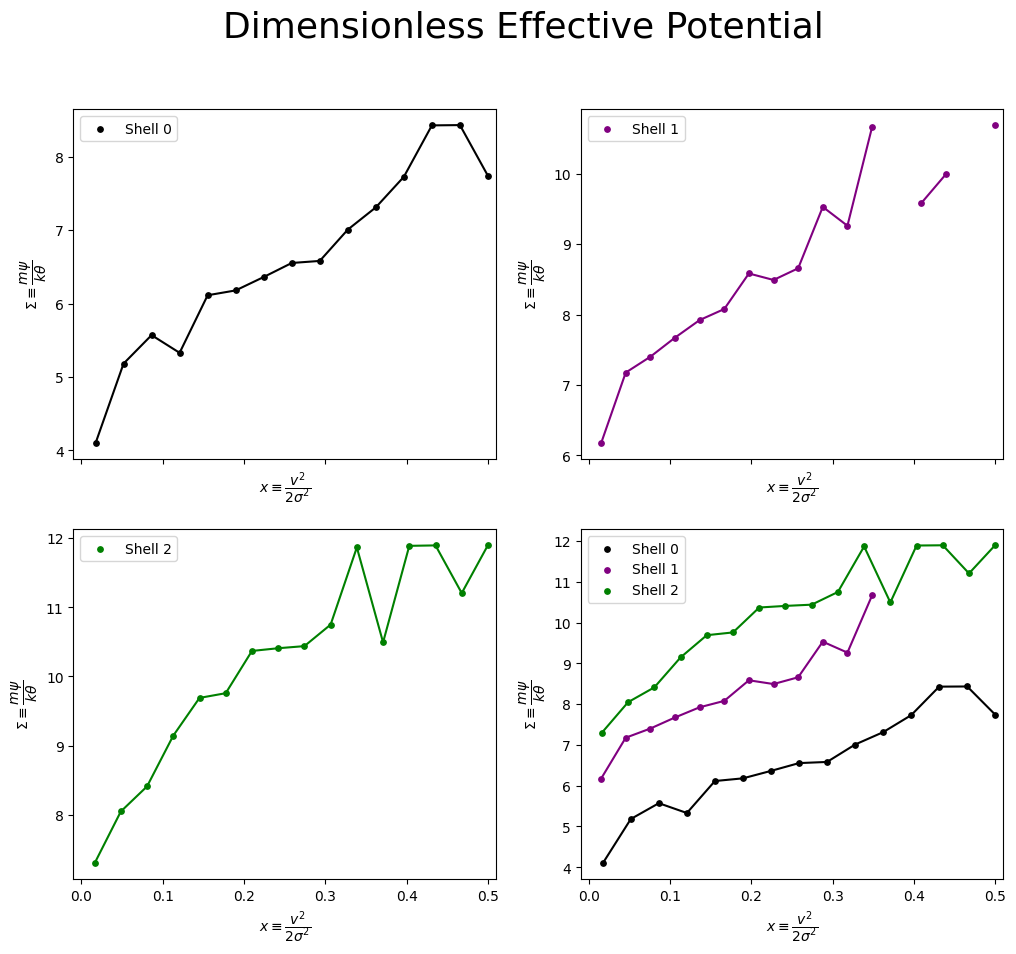

In [11]:
fig, axs = plt.subplots(2, 2, figsize=(12,10), sharex=True)
axs[0,0].scatter(shell0['x'], P0, c='black', label='Shell 0', s=15)
axs[0,0].plot(shell0['x'], P0, c='black')
axs[0,1].scatter(shell1['x'], P1, c='purple', label='Shell 1', s=15)
axs[0,1].plot(shell1['x'], P1, c='purple')
axs[0,1].set_xlim(-0.01,0.51)
axs[1,0].scatter(shell2['x'], P2, c='green', label='Shell 2', s=15)
axs[1,0].plot(shell2['x'], P2, c='green')
axs[1,1].scatter(shell0['x'], P0, c='black', label='Shell 0', s=15)
axs[1,1].plot(shell0['x'], P0, c='black')
axs[1,1].scatter(shell1['x'][0:12], P1[0:12], c='purple', label='Shell 1', s=15)
axs[1,1].plot(shell1['x'][0:12], P1[0:12], c='purple')
axs[1,1].scatter(shell2['x'], P2, c='green', label='Shell 2', s=15)
axs[1,1].plot(shell2['x'], P2, c='green')

fig.suptitle('Dimensionless Effective Potential', fontsize=26)
#fig.supxlabel(r'$x\equiv\dfrac{v^2}{2\sigma^2}$', fontsize=20)
#fig.supylabel(r'$\Sigma \equiv \dfrac{m\psi}{k\theta}$', fontsize=20)

for ax in axs.flat:
    ax.set(xlabel=r'$x\equiv\dfrac{v^2}{2\sigma^2}$', ylabel=r'$\Sigma \equiv \dfrac{m\psi}{k\theta}$')
    ax.legend()
#for ax in axs.flat:
  #ax.label_outer()

Ragionamento merafina su sigma

Creazione sample di velocità quadratiche dalla distribuzione di king

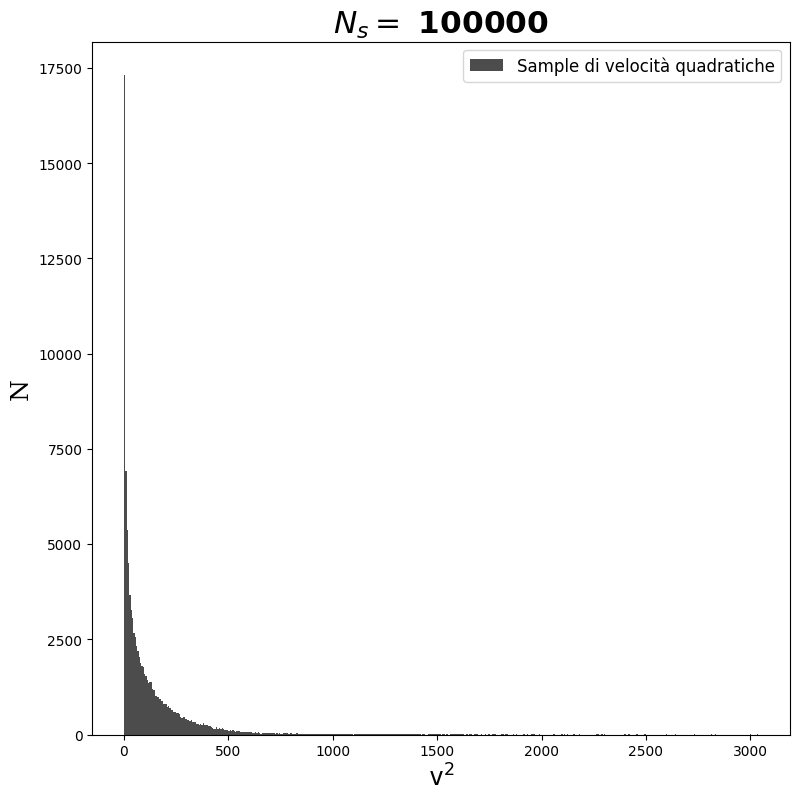

In [20]:
from scipy.stats import maxwell

def bins(N):
  return int(1.5*np.sqrt(N))

def king_distribution(v, sigma, r_c):
    """
    Funzione di distribuzione di King per le velocità quadrate.

    Parameters:
    - v: array di velocità quadrate
    - sigma: dispersione di velocità
    - r_c: raggio core
    """
    king_pdf = (1 / (np.pi * sigma**2 * (1 + (v / (sigma**2 * r_c**2)))))
    king_pdf[np.isnan(king_pdf)] = 0  # Tratta i valori NaN come 0
    return king_pdf

def generate_velocity_sample(n_samples, sigma, r_c):
    """
    Genera un sample di velocità quadratiche dalla distribuzione di King.

    Parameters:
    - n_samples: numero di campioni da generare
    - sigma: dispersione di velocità
    - r_c: raggio core
    """
    # Genera un campione di velocità quadrate dalla distribuzione di Maxwell
    v_sample_maxwell = maxwell.rvs(scale=sigma, size=n_samples)

    # Pondera il campione secondo la distribuzione di King
    weights = king_distribution(np.sqrt(v_sample_maxwell), sigma, r_c)
    weights /= weights.sum()

    # Crea il campione ponderato di velocità quadrate
    v_sample = np.random.choice(v_sample_maxwell, size=n_samples, p=weights)

    return v_sample

n_samples = 100000
s_sample = np.sqrt(s)
r_c = Rc.value

# Genera il sample di velocità quadratiche
v_sample = generate_velocity_sample(n_samples, s_sample, r_c)

# Visualizza l'istogramma
plt.figure(figsize=(9,9))
xs = plt.hist((v_sample-np.mean(v_sample))**2, bins=bins(n_samples), color='black', alpha=0.7, label='Sample di velocità quadratiche')
plt.xlabel(r'$\mathtt{v}^2$', fontdict=label_font)
plt.ylabel('N', fontdict=label_font)
plt.title(r'$N_s=$ {:d}'.format(n_samples), fontdict=title_font)
#plt.ylim(0, 10000)
plt.legend(fontsize='large')
plt.show()


(8.0, 18.0)

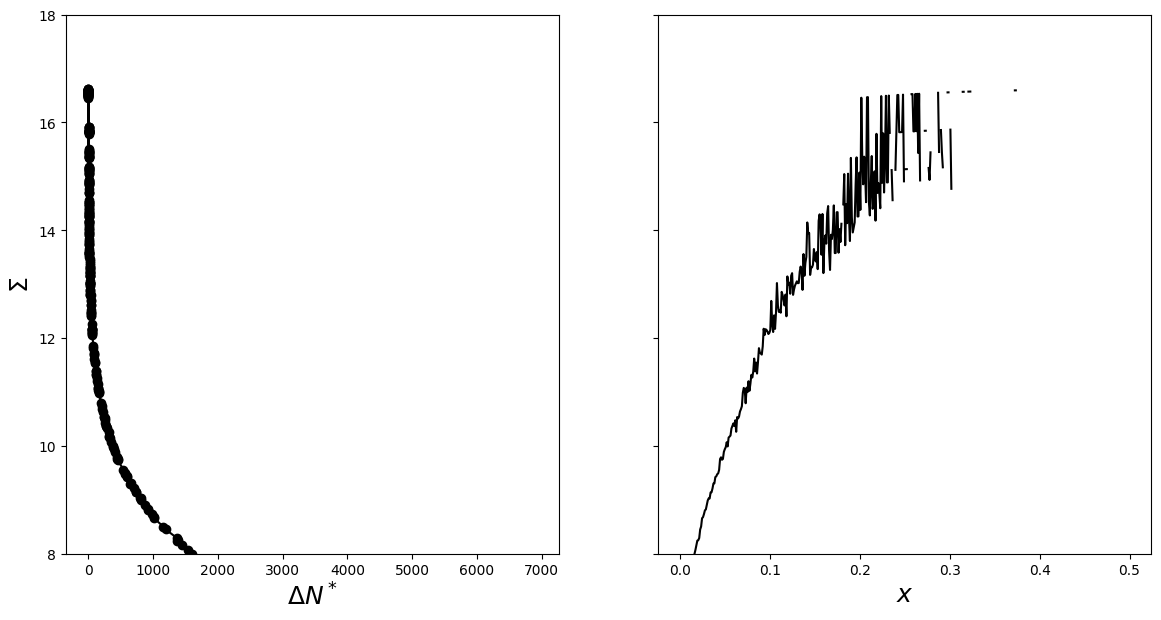

In [21]:
n_sample = xs[0]
x_sample = (xs[1][0:bins(n_samples)])/(2*xs[1].max())
dxs = x_sample[1]-x_sample[0]
R_try = 15.450710                                  # pc
dr_try = 3.433491                                  # pc
# Parametri
alpha = 0.01
beta = 1.
m = 1.
A = 1.
Btot = 16*2**0.5*(np.pi*R_try)**2*(m*s)**3*dxs*dr_try*alpha*beta*A
lnB3 = np.log(Btot)

P_sample = lnB3 - np.log(n_sample/(x_sample**0.5)) - x_sample

fig, axs = plt.subplots(1, 2, figsize=(14,7), sharey=True)
#axs[1].scatter(x_sample, P_sample, c='black')
axs[1].plot(x_sample, P_sample, c='black')
axs[1].set_xlabel(r'$x$', fontdict=label_font)
axs[0].set_ylabel(r'$\Sigma$', fontdict=label_font)

axs[0].scatter(n_sample[1:], P_sample[1:], c='black')
axs[0].plot(n_sample[1:], P_sample[1:], c='black')
axs[0].set_xlabel(r'$\Delta N^*$', fontdict=label_font)

plt.ylim(8,18)

Text(0.5, 1.0, 'Dimensionless Effective potential')

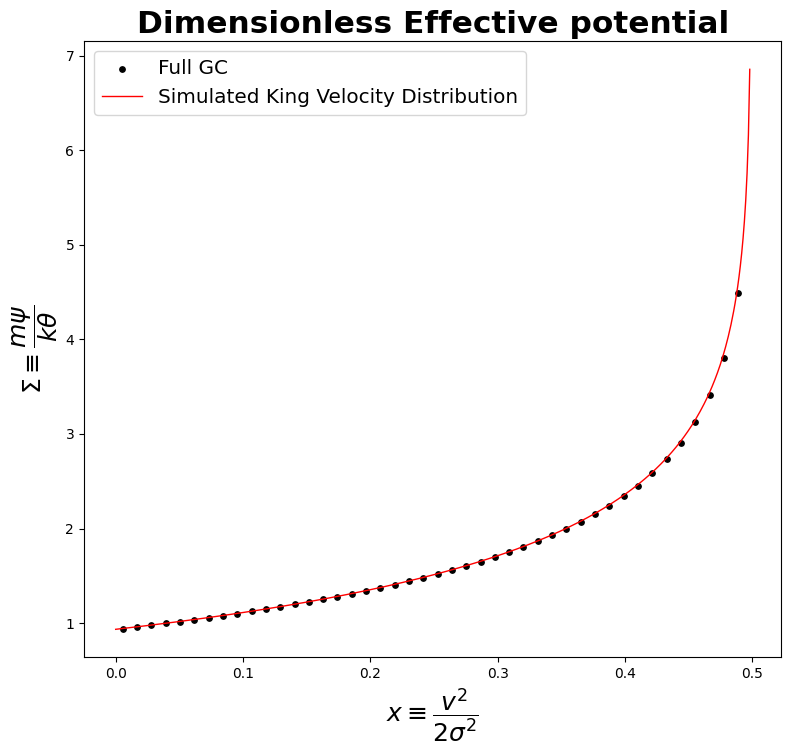

In [22]:
p_sample = -np.log(1-np.exp(x_sample - x_sample.max()))
omega_sample = p_sample + x_sample
f_sim = A*np.exp(-omega_sample)

plt.figure(figsize=(9,8))
plt.scatter(xtot, ptot, c='black', label='Full GC', s=15)
plt.plot(x_sample, p_sample, c='red', linewidth=1, label='Simulated King Velocity Distribution')
plt.legend(fontsize='x-large')
plt.xlabel(r'$x\equiv\dfrac{v^2}{2\sigma^2}$', fontdict=label_font)
plt.ylabel(r'$\Sigma \equiv \dfrac{m\psi}{k\theta}$', fontdict=label_font)
plt.title('Dimensionless Effective potential', fontdict=title_font)

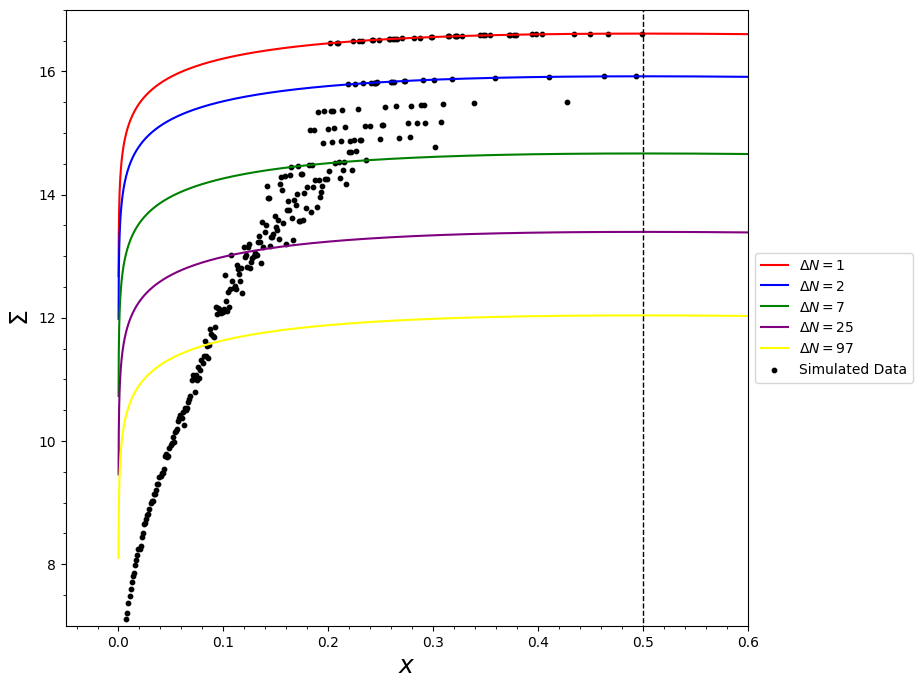

In [26]:
l=np.linspace(0,0.7, 10000)
def Sigma(x, n, simulation=False):
  if simulation==False:
    return (lnB2-np.log(n/x**0.5)-x)
  if simulation==True:
    return (lnB3-np.log(n/x**0.5)-x)

SIM = True

fig, ax = plt.subplots(figsize=(11,8))

if SIM == True:
  # Simulato
  plt.plot(l, Sigma(l, 1, simulation=SIM), c='red', label='$\Delta N = 1$')
  plt.plot(l, Sigma(l, 2, simulation=SIM), c='blue', label='$\Delta N = 2$')
  plt.plot(l, Sigma(l, 7, simulation=SIM), c='green', label='$\Delta N = 7$')
  plt.plot(l, Sigma(l, 25, simulation=SIM), c='purple', label='$\Delta N = 25$')
  plt.plot(l, Sigma(l, 97, simulation=SIM), c='yellow', label=r'$\Delta N=97$')
  plt.xlim(-0.05,0.6)

  plt.scatter(x_sample, P_sample, c='black', s=10, label='Simulated Data')
  plt.ylim(7, 17)
if SIM == False:
  # Real data
  plt.plot(l, Sigma(l, 1, simulation=SIM), c='red', label='$\Delta N = 1$')
  plt.plot(l, Sigma(l, 2, simulation=SIM), c='blue', label='$\Delta N = 2$')
  plt.plot(l, Sigma(l, 7, simulation=SIM), c='green', label='$\Delta N = 7$')
  plt.plot(l, Sigma(l, 25, simulation=SIM), c='purple', label='$\Delta N = 25$')
  plt.plot(l, Sigma(l, 97, simulation=SIM), c='yellow', label=r'$\Delta N=97$')
  plt.xlim(-0.05,0.6)
  #plt.scatter(xtot, Ptot, c='black', s=15, label='Observed data')
  plt.ylim(13,22)


plt.plot([0.5,0.5], [0,23], c='black', linestyle='--', linewidth=1)
ax.minorticks_on()
plt.legend(fontsize='large')
plt.xlabel(r'$x$', fontdict=label_font)
plt.ylabel(r'$\Sigma$', fontdict=label_font)
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [ ]:
def Sigma2(x):
    return (lnB2-np.log((128-x*256)/x**0.5)-x)

plt.plot(l, Sigma2(l))
plt.ylim(12, 22)

#Calcolo voto laurea

In [ ]:
VotoRelatore = 30
VotoControrelatore = 30
Media = 29
Presentazione = 3
a = 75/120
b = 45/120

Voto = (VotoRelatore + VotoControrelatore)*0.5

print(11/3*(Media*a + Voto*b) + Presentazione)

110.70833333333333
